In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.preprocessing.image as tf_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.image as tf_image
from scipy.io import loadmat
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adadelta
from PIL import Image
from tensorflow.keras.applications import DenseNet169, VGG16, Xception, ResNet152V2
from sklearn.manifold import TSNE
import re
import warnings
for i in [DeprecationWarning,FutureWarning,UserWarning]:
    warnings.filterwarnings("ignore", category = i)

In [2]:

mat_train = loadmat('devkit/cars_train_annos.mat')
mat_test = loadmat('devkit/cars_test_annos.mat')
meta = loadmat('devkit/cars_meta.mat')

labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])

i = 0
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    train.append((image,label))
    i += 1
    if i > 100:
        pass


In [3]:
len(train)

8144

In [4]:
len(labels)

196

In [5]:
im_list_train=[]
label_list_train=[]
for pic in train:
    img = Image.open("cars/cars_train/cars_train/" + pic[0]).convert("RGB")
    if img is not None:
        img = img.resize((300, 300))
        im_list_train.append(img)
    else:
        print("emptytrain")

        
im_list_train = np.array(im_list_train)

In [6]:
im_list_train.shape

(8144,)

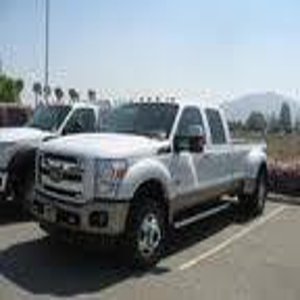

In [7]:
im_list_train[4]

In [8]:
(np.array(im_list_train[10])).shape

(300, 300, 3)

In [9]:
df = pd.DataFrame(train, columns=['filename', 'model'])

In [10]:
df

,filename,model
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012
...,...,...
8139,08140.jpg,Chrysler Town and Country Minivan 2012
8140,08141.jpg,smart fortwo Convertible 2012
8141,08142.jpg,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,Ford GT Coupe 2006


In [11]:
def generate_triplets(dataset, models, length=10):
    x, y = None, None
    for model in models:
        pos_indices = dataset.loc[(dataset['model'] == model)].index
        neg_indices = dataset.loc[(dataset['model'].isin(models)) & (dataset['model'] != model)].index
        choice_anchor_indices = np.random.choice(pos_indices, length, replace=True) # replace=(len(pos_indices) < length))
        choice_anchor_images = list(map(lambda x: (np.array(im_list_train[x]))/255, choice_anchor_indices))
        
#         pos_indices = np.setdiff1d(pos_indices, choice_anchor_indices)
        choice_pos_indices = np.random.choice(pos_indices, length, replace=(len(pos_indices) < length)) # (len(pos_indices) < length))
        choice_neg_indices = np.random.choice(neg_indices, length, replace=(len(pos_indices) < length)) # (len(neg_indices) < length))
        choice_pos_images = list(map(lambda x: np.array(im_list_train[x])/255, choice_pos_indices))
        choice_neg_images = list(map(lambda x: np.array(im_list_train[x])/255, choice_neg_indices))
        choice_neg_labels = list(map(lambda x: dataset.loc[x]['model'], choice_neg_indices))

        if x is None:
            x = [(choice_anchor_images), (choice_pos_images), (choice_neg_images)]
            y = [[model]*length, [model]*length, choice_neg_labels]
        else:
            x[0] = np.concatenate((x[0], choice_anchor_images))
            x[1] = np.concatenate((x[1], choice_pos_images))
            x[2] = np.concatenate((x[2], choice_neg_images))
            y[0] = np.hstack((y[0], [model]*length))
            y[1] = np.hstack((y[1], [model]*length))
            y[2] = np.hstack((y[2], choice_neg_labels))
    return x, y

In [12]:
train_x, train_y = generate_triplets(df, [labels[6], labels[12], labels[40], labels[77], labels[106], labels[143], labels[27], labels[49], labels[80], labels[120], labels[166], labels[169]], 100)

In [13]:
labels[106]

'Ford Mustang Convertible 2007'

In [14]:
np.unique(train_y[0])

array(['Acura ZDX Hatchback 2012', 'Audi A5 Coupe 2012',
       'BMW 1 Series Coupe 2012', 'Bentley Mulsanne Sedan 2011',
       'Buick Enclave SUV 2012', 'Chrysler PT Cruiser Convertible 2008',
       'Chrysler Town and Country Minivan 2012',
       'Ford Mustang Convertible 2007', 'GMC Acadia SUV 2012',
       'Jaguar XK XKR 2012', 'Mitsubishi Lancer Sedan 2012',
       'Nissan Juke Hatchback 2012'], dtype='<U38')

In [15]:
np.asarray(train_x[2]).shape

(1200, 300, 300, 3)

In [16]:
np.asarray(train_y[2]).shape

(1200,)

In [17]:
def visualize_data(data, n):
    fig, ax = plt.subplots(n, 3, figsize=(20,20))
    for i in range(n):
        img_anc = data[0][i] 
        img_pos = data[1][i] 
        img_neg = data[2][i] 
        ax[i, 0].imshow(img_anc)
        ax[i, 1].imshow(img_pos)
        ax[i, 2].imshow(img_neg)

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

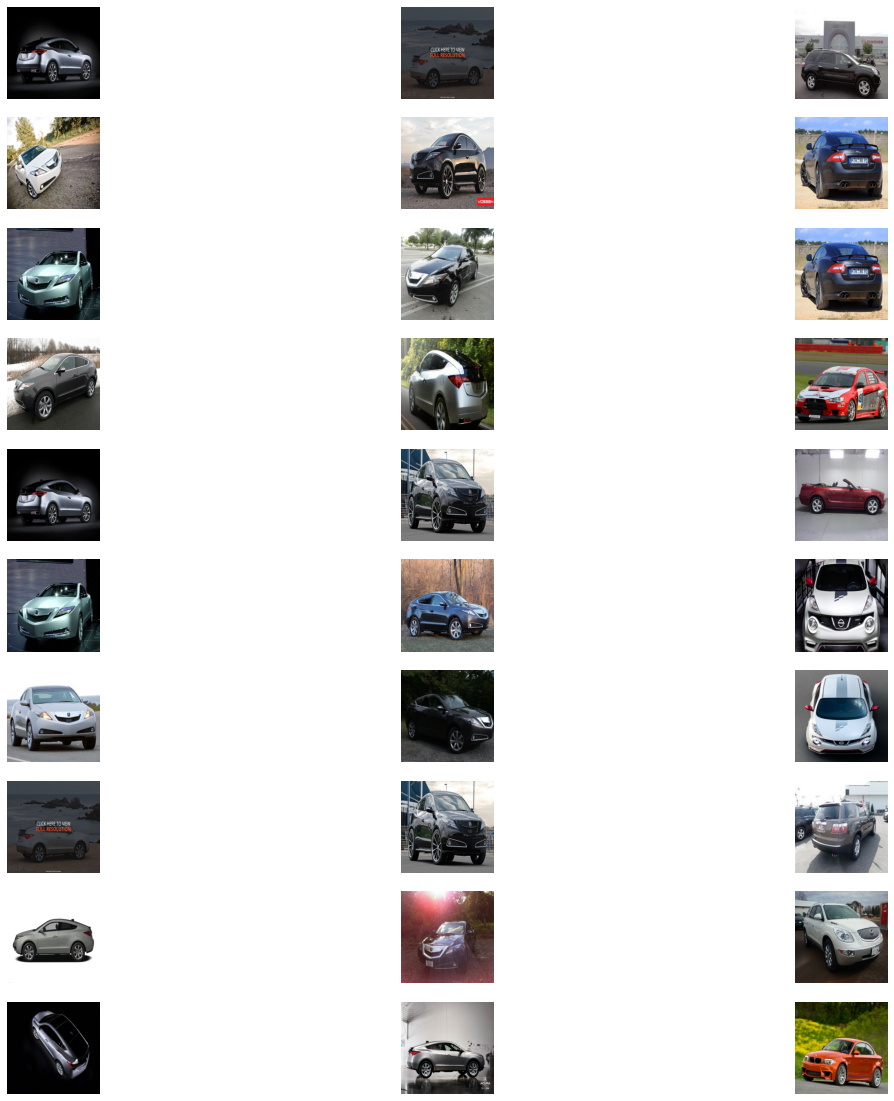

In [18]:
visualize_data(train_x, 10)

In [19]:
def triplet_loss(inputs, alpha=1, dist='sqeuclidean'):
    anchor, positive, negative = inputs
    positive_distance = tf.square(tf.subtract(anchor, positive))
    negative_distance = tf.square(tf.subtract(anchor, negative))
    if dist == 'euclidean':
        positive_distance = tf.sqrt(tf.reduce_sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = tf.sqrt(tf.reduce_sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = tf.reduce_sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = tf.reduce_sum(negative_distance, axis=-1, keepdims=True)
    loss = tf.subtract(positive_distance, negative_distance)
    loss = tf.maximum(0.0, alpha + loss)
    return tf.reduce_mean(loss)

In [20]:
def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    conv_base = ResNet152V2(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
    conv_base.trainable = False
    x = conv_base(_input)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(192, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(embedding_dim, activation="sigmoid")(x)
    return Model(_input, x), conv_base

In [21]:
def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):

    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    encoded_anchor = embedding_model[0](anchor_input)
    encoded_positive = embedding_model[0](positive_input)
    encoded_negative = embedding_model[0](negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    siamese_triplet.add_loss(triplet_loss(outputs, triplet_margin))
    
    return siamese_triplet, embedding_model

In [22]:
siamese_triplet, embedding_model = get_siamese_model((300,300,3), triplet_margin=20, embedding_dim=320)
siamese_triplet.compile(optimizer=Adam(0.00005) ) 

In [23]:
embedding_model[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         2359424   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 192)         221376    
_________________________________________________________________
flatten (Flatten)            (None, 6912)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               2212160   
Total params: 63,124,608
Trainable params: 4,792,960
Non-trainable params: 58,331,648
_________________________________________

In [24]:
class BatchGenerator(k.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x = x_set.copy()
        self.y = y_set.copy()
        self.batch_size = batch_size

    def on_epoch_end(self):
        models = np.unique(self.y[0])
        x1 = np.empty((len(self.x[1]), 300, 300, 3))
        x2 = []
        y2 = np.empty(len(self.y[0]), dtype="<U6")
        for model in models:
            pos_indices = np.argwhere(self.y[1] == model).flatten()
            length = len(pos_indices)

            neg_indices = np.argwhere(self.y[2] != model).flatten()
            choice_neg_indices = np.random.choice(neg_indices, length, replace=False)
            y2[pos_indices] = self.y[2][choice_neg_indices]

            x2 = x2 + [self.x[2][index] for index in choice_neg_indices]

            choice_pos_indices = np.random.choice(pos_indices, length, replace=False)
            for i, index in zip(pos_indices, choice_pos_indices):
                x1[i] = self.x[1][index]
      
        self.x = [self.x[0], x1, x2]
        self.y[2] = y2

    def __len__(self):
        return int(np.ceil(len(self.x[0]) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = [self.x[0][idx * self.batch_size:(idx + 1) * self.batch_size], 
                   self.x[1][idx * self.batch_size:(idx + 1) * self.batch_size], 
                   self.x[2][idx * self.batch_size:(idx + 1) * self.batch_size]]

        return batch_x #, batch_y 


In [25]:
batch_size = 20   
batchGenerator = BatchGenerator(train_x, train_y, batch_size)

In [26]:
n_epochs = 42
history = siamese_triplet.fit(batchGenerator,  epochs=n_epochs)

Epoch 1/42
60/60 [==============================] - 50s 508ms/step - loss: 12.9139
Epoch 2/42
60/60 [==============================] - 31s 515ms/step - loss: 7.6286
Epoch 3/42
60/60 [==============================] - 31s 517ms/step - loss: 5.8367
Epoch 4/42
60/60 [==============================] - 31s 520ms/step - loss: 3.5482
Epoch 5/42
60/60 [==============================] - 31s 522ms/step - loss: 2.8377
Epoch 6/42
60/60 [==============================] - 31s 523ms/step - loss: 2.5916
Epoch 7/42
60/60 [==============================] - 31s 524ms/step - loss: 2.2507
Epoch 8/42
60/60 [==============================] - 32s 528ms/step - loss: 1.7675
Epoch 9/42
60/60 [==============================] - 32s 526ms/step - loss: 1.7912
Epoch 10/42
60/60 [==============================] - 32s 527ms/step - loss: 1.6904
Epoch 11/42
60/60 [==============================] - 32s 529ms/step - loss: 1.1093
Epoch 12/42
60/60 [==============================] - 32s 527ms/step - loss: 1.3965
Epoch 13/42


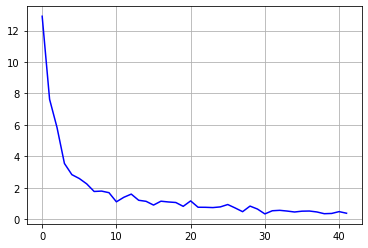

In [27]:
plt.grid()
plt.plot(history.history["loss"], color="blue");
# plt.plot(history2.history["loss"], color="red");

In [28]:
def compute_2d(embeddings, metric='cosine', learning_rate=200):
    model = TSNE(learning_rate=learning_rate, metric=metric)
    return model.fit_transform(embeddings)
colors = np.array([[np.random.randint(i+1, 2*i+2, 1)]*100 for i in range(12)]).flatten()

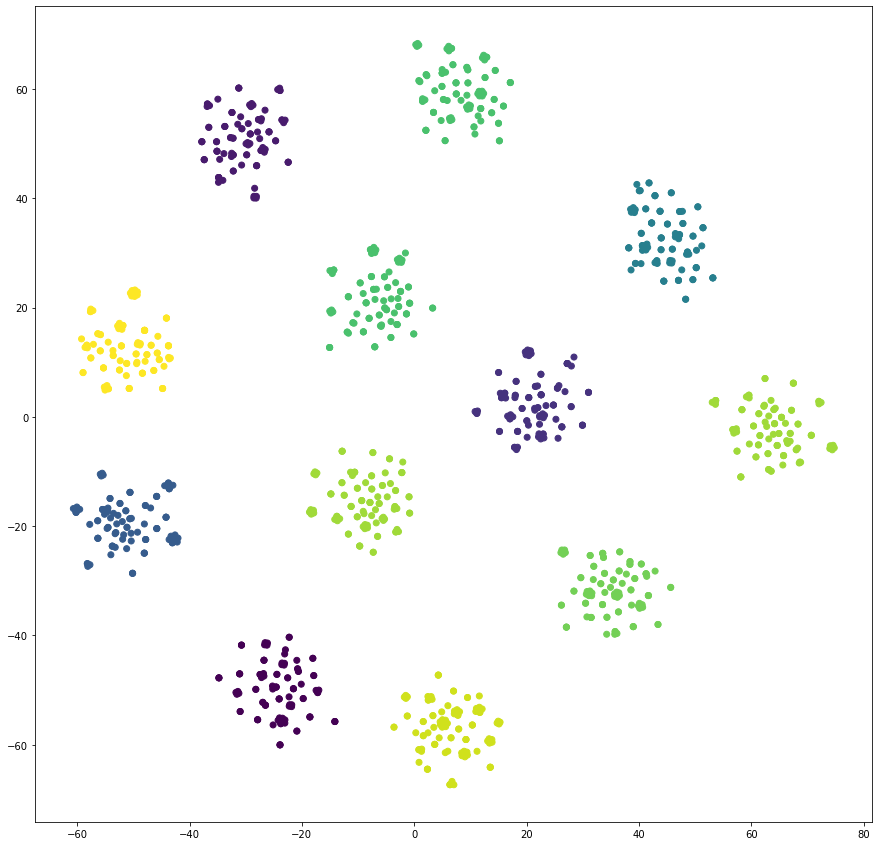

In [29]:
predicts = embedding_model[0].predict(train_x[0])
embeddings_train = compute_2d(predicts, 'cosine', 50)

plt.figure(figsize=(15,15))
x, y = embeddings_train[:, 0], embeddings_train[:, 1]
plt.scatter(x, y, c=colors)
plt.show()

In [30]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
    classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
    classifier.fit(img_encoding, img_class)
    return classifier

In [31]:
train_embeds = embedding_model[0].predict(train_x[0])
target = np.squeeze(train_y[0])
classifier = fit_nearest_neighbor(train_embeds, target)
op = classifier.predict(train_embeds)
(np.where(np.squeeze(train_y[0]) == op))[0].shape[0] / train_y[0].shape[0]


1.0

In [32]:
def accuracy(predictions, filenames):
    total = len(predictions)
    accurate = 0
    for i, pred in enumerate(predictions):
        if filenames[i].startswith(pred):
            accurate += 1
    return accurate / total
        

In [33]:
im_list_test=[]
label_list_test=[]
for i, file_name in enumerate(sorted(os.listdir('cars/cars_test/'))):
    if file_name.startswith("cars_test") or file_name.startswith("."):
        continue
    test_img = Image.open("cars/cars_test/" + file_name).convert("RGB")
    test_img = test_img.resize((300,300))
    test_img = np.array(test_img)/255
    im_list_test.append(test_img)
    label_list_test.append(file_name)
     
im_list_test = np.array(im_list_test)

In [34]:
test_embeds = embedding_model[0].predict(im_list_test)
op = classifier.predict(test_embeds)
accuracy(op, label_list_test)


0.711764705882353

Достигнута точность ~72%.

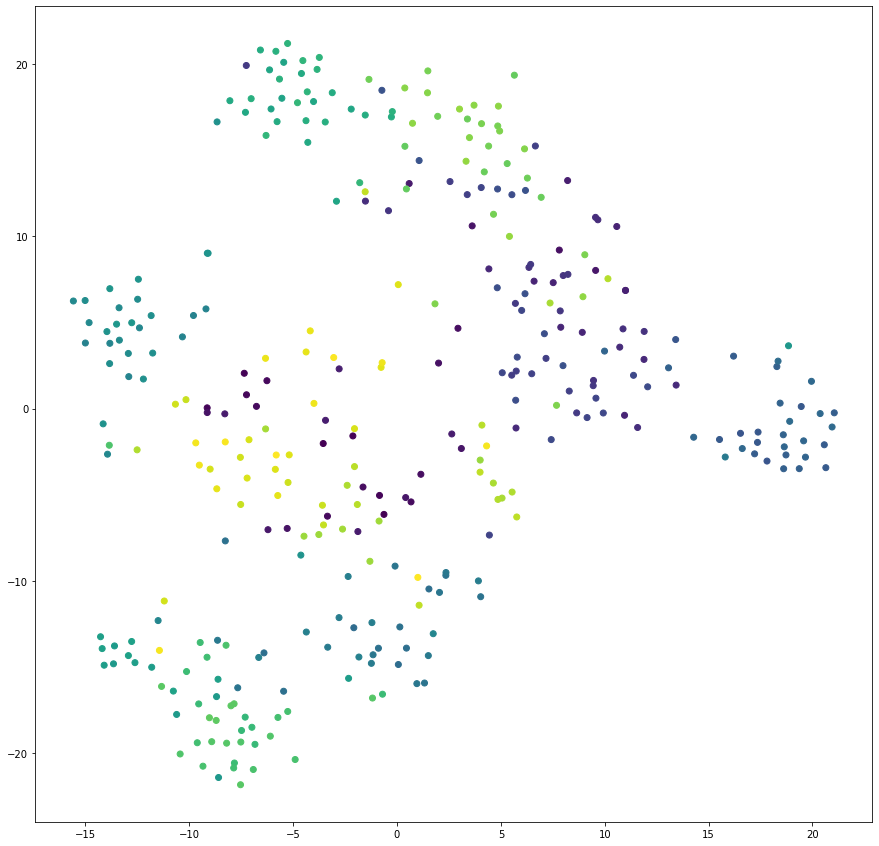

In [35]:
embeddings_test = compute_2d(test_embeds, 'cosine', 50)
colors = np.array([i for i, label in enumerate(label_list_test)]).flatten()
plt.figure(figsize=(15,15))
x, y = embeddings_test[:, 0], embeddings_test[:, 1]
plt.scatter(x, y, c=colors)
plt.show()